In [27]:
#Git clone the ddsp_textures repo in the parent directory if you haven't already
import os
import subprocess

# Define the path where you want to clone the repository
repo_url = "https://github.com/cordutie/ddsp_textures.git"
clone_path = os.path.abspath(os.path.join('..', '..', 'ddsp_textures'))

# Check if the directory already exists
if not os.path.exists(clone_path):
    print(f"Cloning the repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path])
    print("Repository cloned successfully.")
else:
    print(f"The repository already exists at {clone_path}.")

The repository already exists at /home/esteban/Desktop/ddsp_textures_thesis/ddsp_textures.


In [28]:
#Add the ddsp's parent directory to the Python path so that we can import the necessary modules
import sys

ddsp_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if ddsp_dir not in sys.path:
    sys.path.append(ddsp_dir)

In [29]:
# import modules
import ddsp_textures.signal_processors.synthesizers as sp
import ddsp_textures.auxiliar.time_stamps           as ts
import ddsp_textures.architectures.VAE               as VAE

# Extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
import itertools

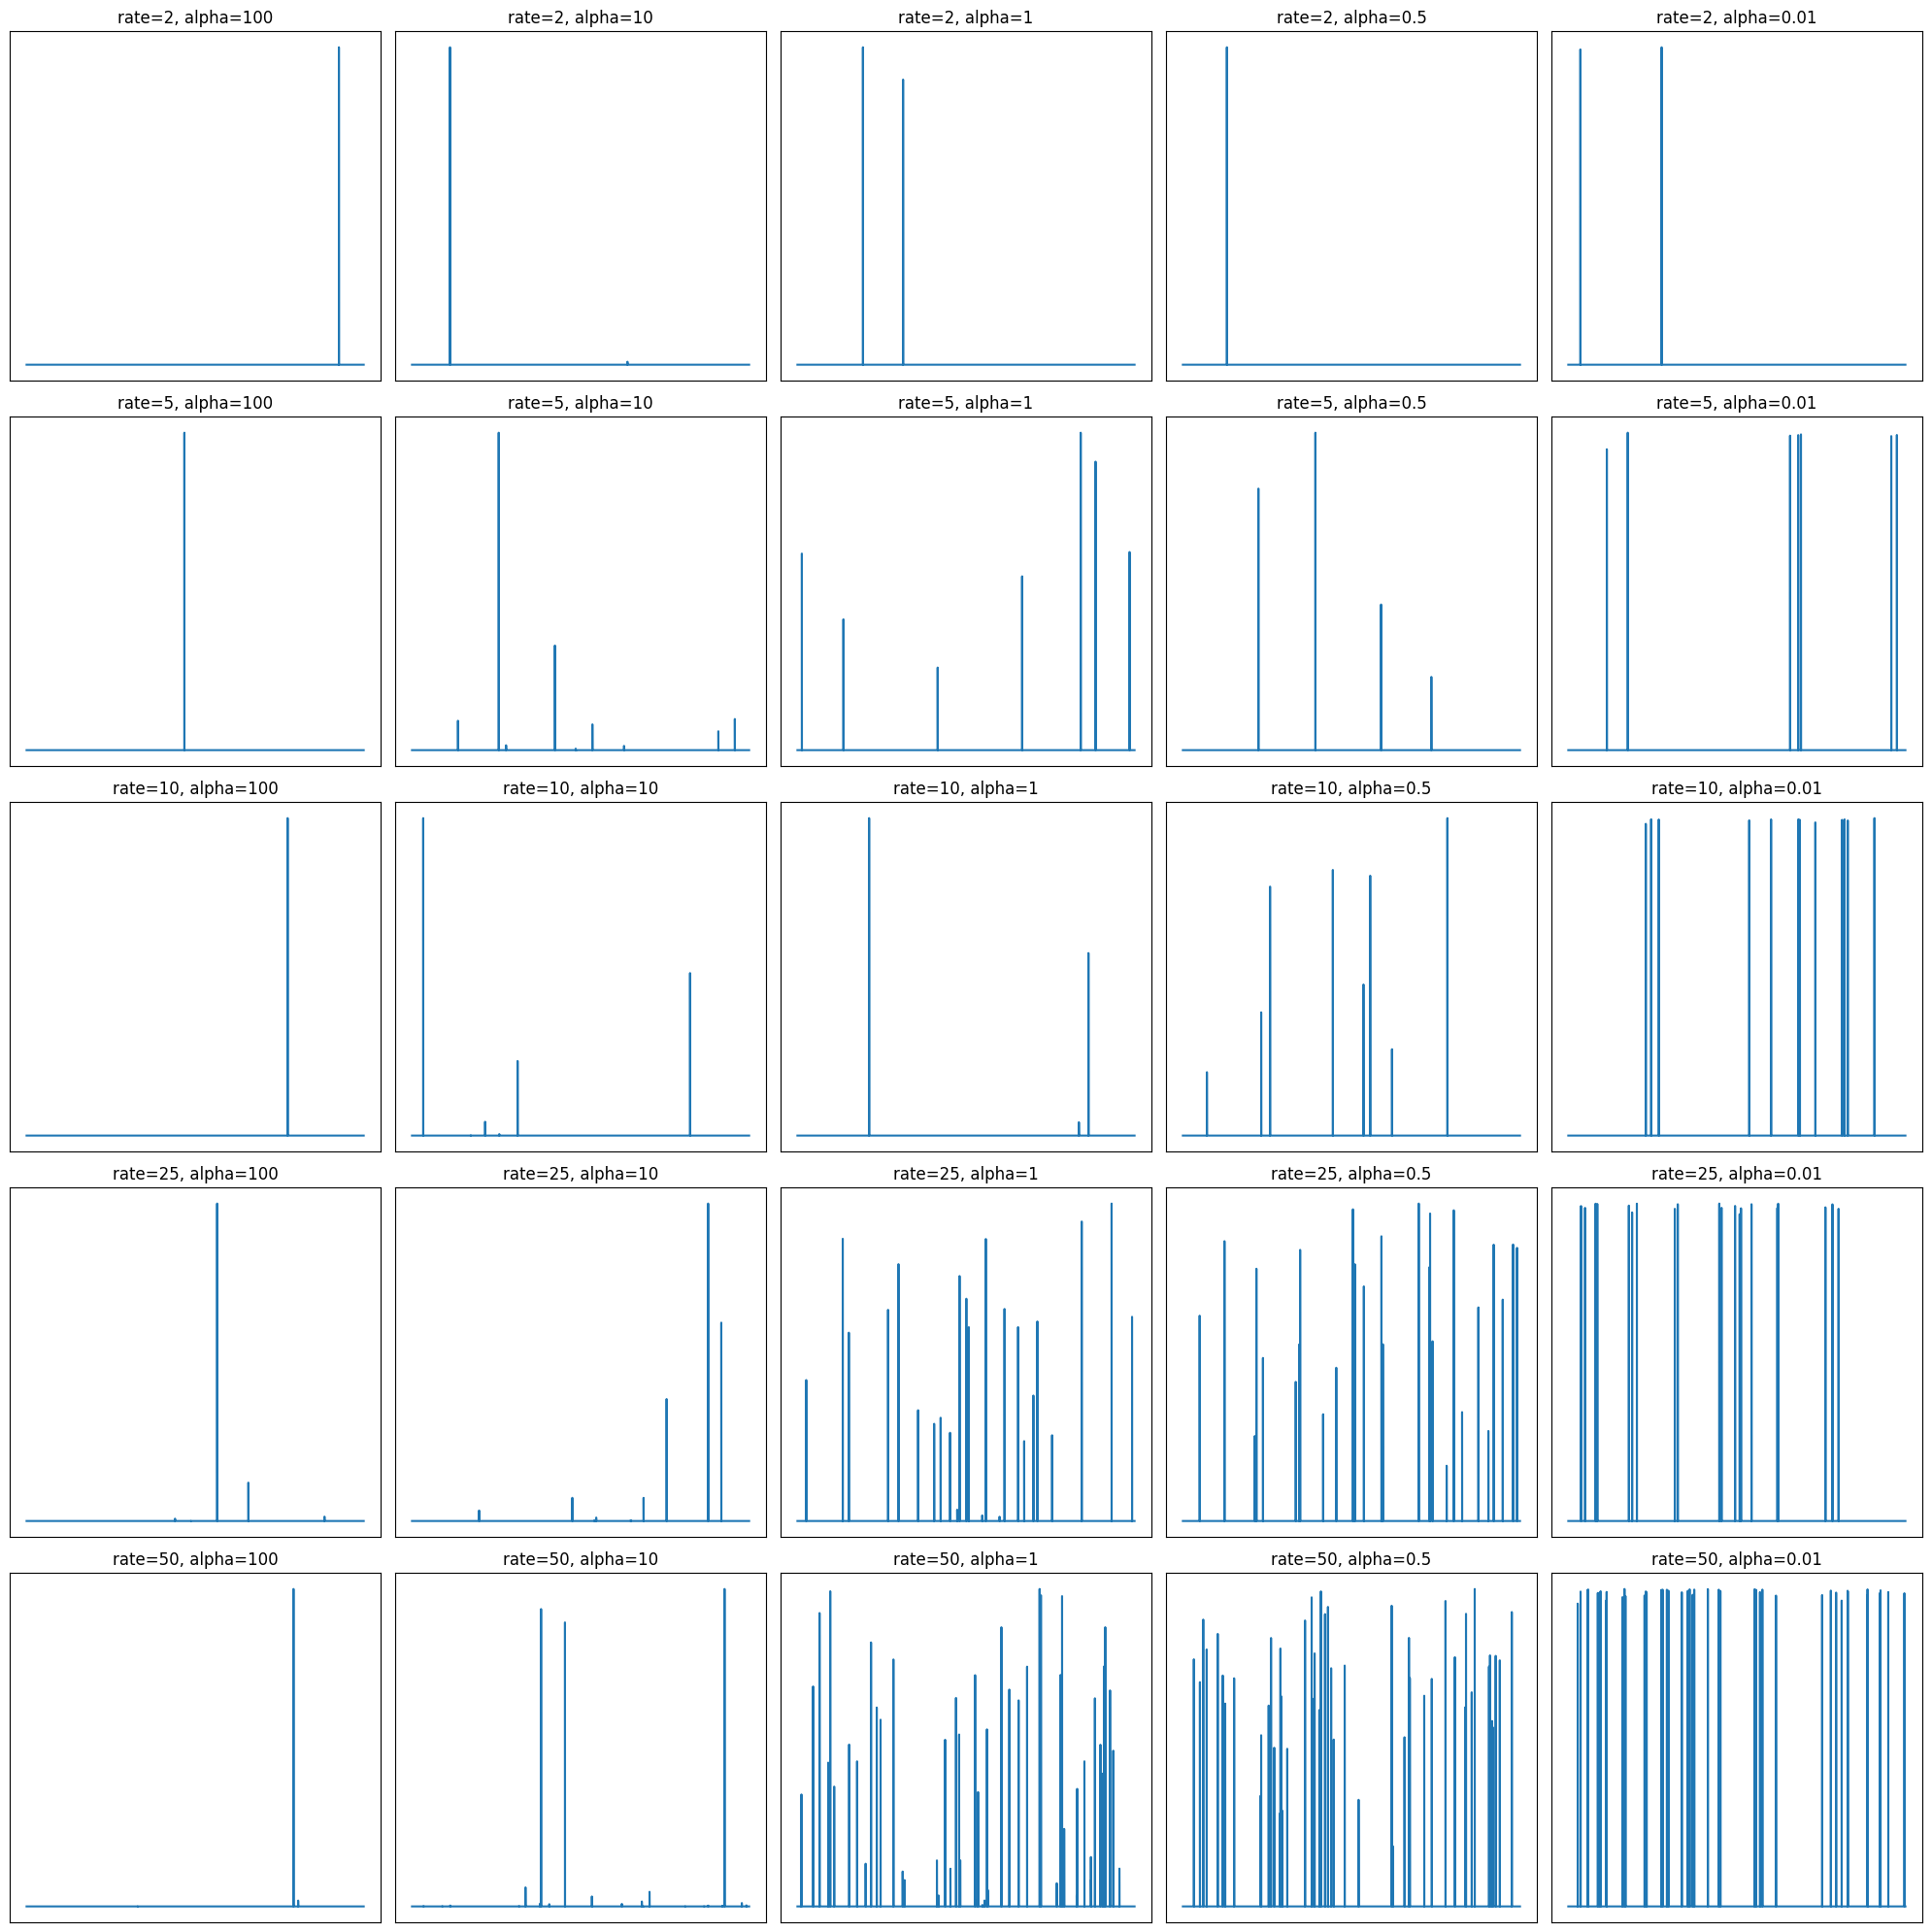

In [30]:
# Provided lists of parameters
rates = [2, 5, 10, 25, 50]
alphas = [100, 10, 1, 0.5, 0.01]

# Provided constants
sr = torch.tensor(44100.)  # standard sr
size = 44100  # 1 second

# Grid size
n_rows = len(rates)
n_cols = len(alphas)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

# Iterate over all combinations of rates and alphas
for i, (rate, alpha) in enumerate(itertools.product(rates, alphas)):
    row = i // n_cols
    col = i % n_cols

    # Generate the time_stamp tensor
    time_stamp = ts.time_stamps_generator(size, sr, rate, alpha)

    # Plot on the corresponding subplot
    axes[row, col].plot(time_stamp.numpy())
    axes[row, col].set_title(f'rate={rate}, alpha={alpha}')
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])

# Adjust the layout
plt.tight_layout()
plt.show()

/tmp/ipykernel_2549206/89941729.py:4: RuntimeWarning: divide by zero encountered in power
  return (1/alpha) * np.power(x,((1-alpha)/alpha))


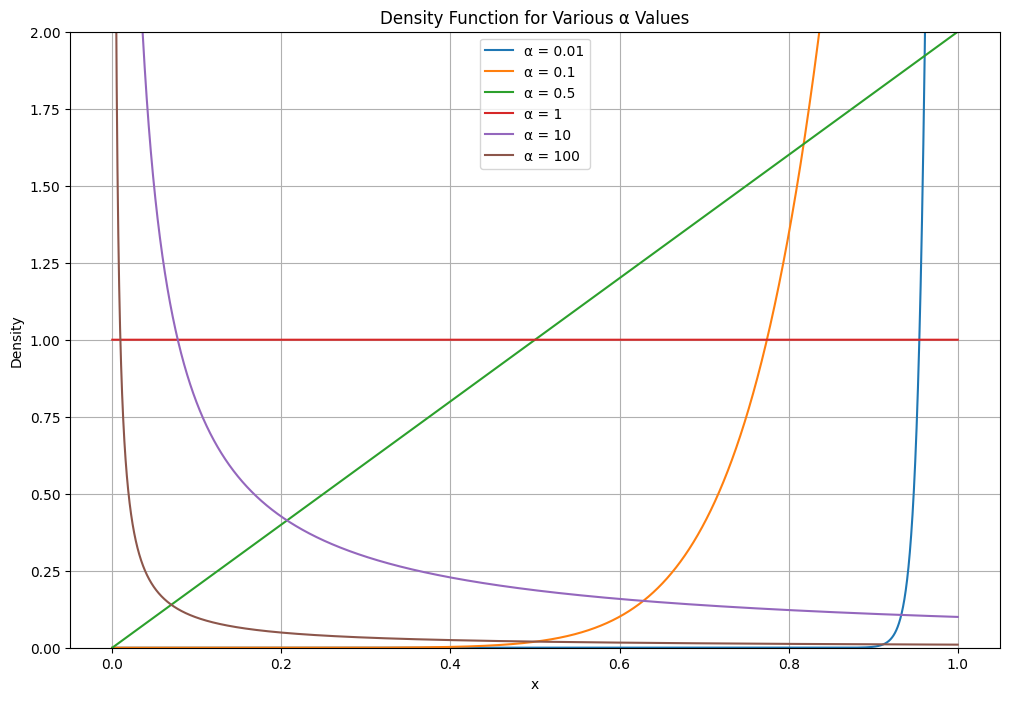

In [31]:
# Distribution of amplitudes 

def density(x, alpha):
    return (1/alpha) * np.power(x,((1-alpha)/alpha))

def riemann_sum(alpha, n=100000000):
    x = np.linspace(0, 1, n+1)
    dx = 1 / n
    y = density(x[:-1] + dx/2, alpha)
    return np.sum(y * dx)    
    

# Values for alpha
alpha_values = [0.01, 0.1, 0.5, 1, 10, 100]

# Plotting the density functions
x = np.linspace(0, 1, 10000)
plt.figure(figsize=(12, 8))

for alpha in alpha_values:
    plt.plot(x, density(x, alpha), label=f'α = {alpha}')

plt.xlabel('x')
plt.ylabel('Density')
plt.ylim(0, 2)
plt.title('Density Function for Various α Values')
plt.legend()
plt.grid(True)
plt.savefig('density_functions.png')
plt.show()

# # Approximating the integral using Riemann sums
# integrals = {}
# for alpha in alpha_values:
#     integral_approx = riemann_sum(alpha)
#     integrals[alpha] = integral_approx

# # Print the results
# for alpha, integral in integrals.items():
#     print(f'Approximate integral for α = {alpha}: {integral:.4f}')

In [32]:
# Function to display latent space of VAE
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Display latent space
import torch
import numpy as np
from IPython.display import Audio, display, HTML

def display_latent_space(model, device, sr=44100):
    # Define the grid in the latent space
    grid_size = 5  # Adjust this for more/less granularity
    latents = np.linspace(-1, 1, grid_size)
    latent_grid = np.array([[x, y] for x in latents for y in latents])

    # Initialize an empty list to store the generated sounds
    generated_sounds = []

    # Generate sounds for each point in the latent space grid
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for latent_vector in latent_grid:
            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device)
            # latent_tensor = latent_tensor.unsqueeze(0)  # Add batch dimension

            # Generate sound using the VAE's generate function
            generated_sound = model.generate(latent_tensor)

            # Store the generated sound in the list
            generated_sounds.append(generated_sound.cpu().numpy().flatten())  # Flatten to 1D array and move to CPU

    # Reshape the generated sounds into a matrix form
    generated_sounds_matrix = np.array(generated_sounds).reshape(grid_size, grid_size, -1)

    # Display the sounds in a grid layout
    grid_html = "<table>"
    for i in range(grid_size):
        grid_html += "<tr>"
        for j in range(grid_size):
            grid_html += "<td>"
            sound_html = f"Latent: ({latent_grid[i*grid_size+j][0]:.2f}, {latent_grid[i*grid_size+j][1]:.2f})"
            sound_html += "<br>"
            sound_html += Audio(generated_sounds_matrix[i, j, :], rate=sr)._repr_html_()
            grid_html += sound_html
            grid_html += "</td>"
        grid_html += "</tr>"
    grid_html += "</table>"

    display(HTML(grid_html))

In [33]:
# Load pretrained VAE on fire crackling sounds
model_path          = '../data/models/VAE_SubEnv/fire/best_model.pth'
model_settings_path = '../data/models/VAE_SubEnv/fire/best_model_settings.json'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = VAE.load_model(model_path, model_settings_path, device)

#Display latent space
display_latent_space(model, device)

Model loaded from ../data/models/VAE_SubEnv/fire/best_model.pth
